# PREPARATION

## Import classes

In [1]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        # xSquared = np.multiply(self.x , self.x)
        # ySquared = np.multiply(self.y, self.y)
        # zSquared = np.multiply(self.z, self.z)
        # self.mag = np.sqrt(np.add(xSquared, ySquared, zSquared))
        # Fixed April 26, 2018 based on class comment by Krzysztof D.
        self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        self.gyro = SensorData("Gyroscope", *parsedGyroLogData[1:])
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))

## File handling and parsing

In [2]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

## Data Logging

In [3]:
# Load the data

logPath = './JonGestureLogs'
logPath_me = "./MyGestureLogs"

mapGestureToTrials = parse_and_create_gesture_trials(logPath)
mapGestureToTrials_me = parse_and_create_gesture_trials(logPath_me)

Found 100 csv files in ./JonGestureLogs
Found 10 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'At Rest' Trial 3 with 323 sensor events. Resizing all arrays to match
Found 112 csv files in ./MyGestureLogs
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Wave'
Max trial length across all ges

## Visualisation

### Jon Gesture Logs

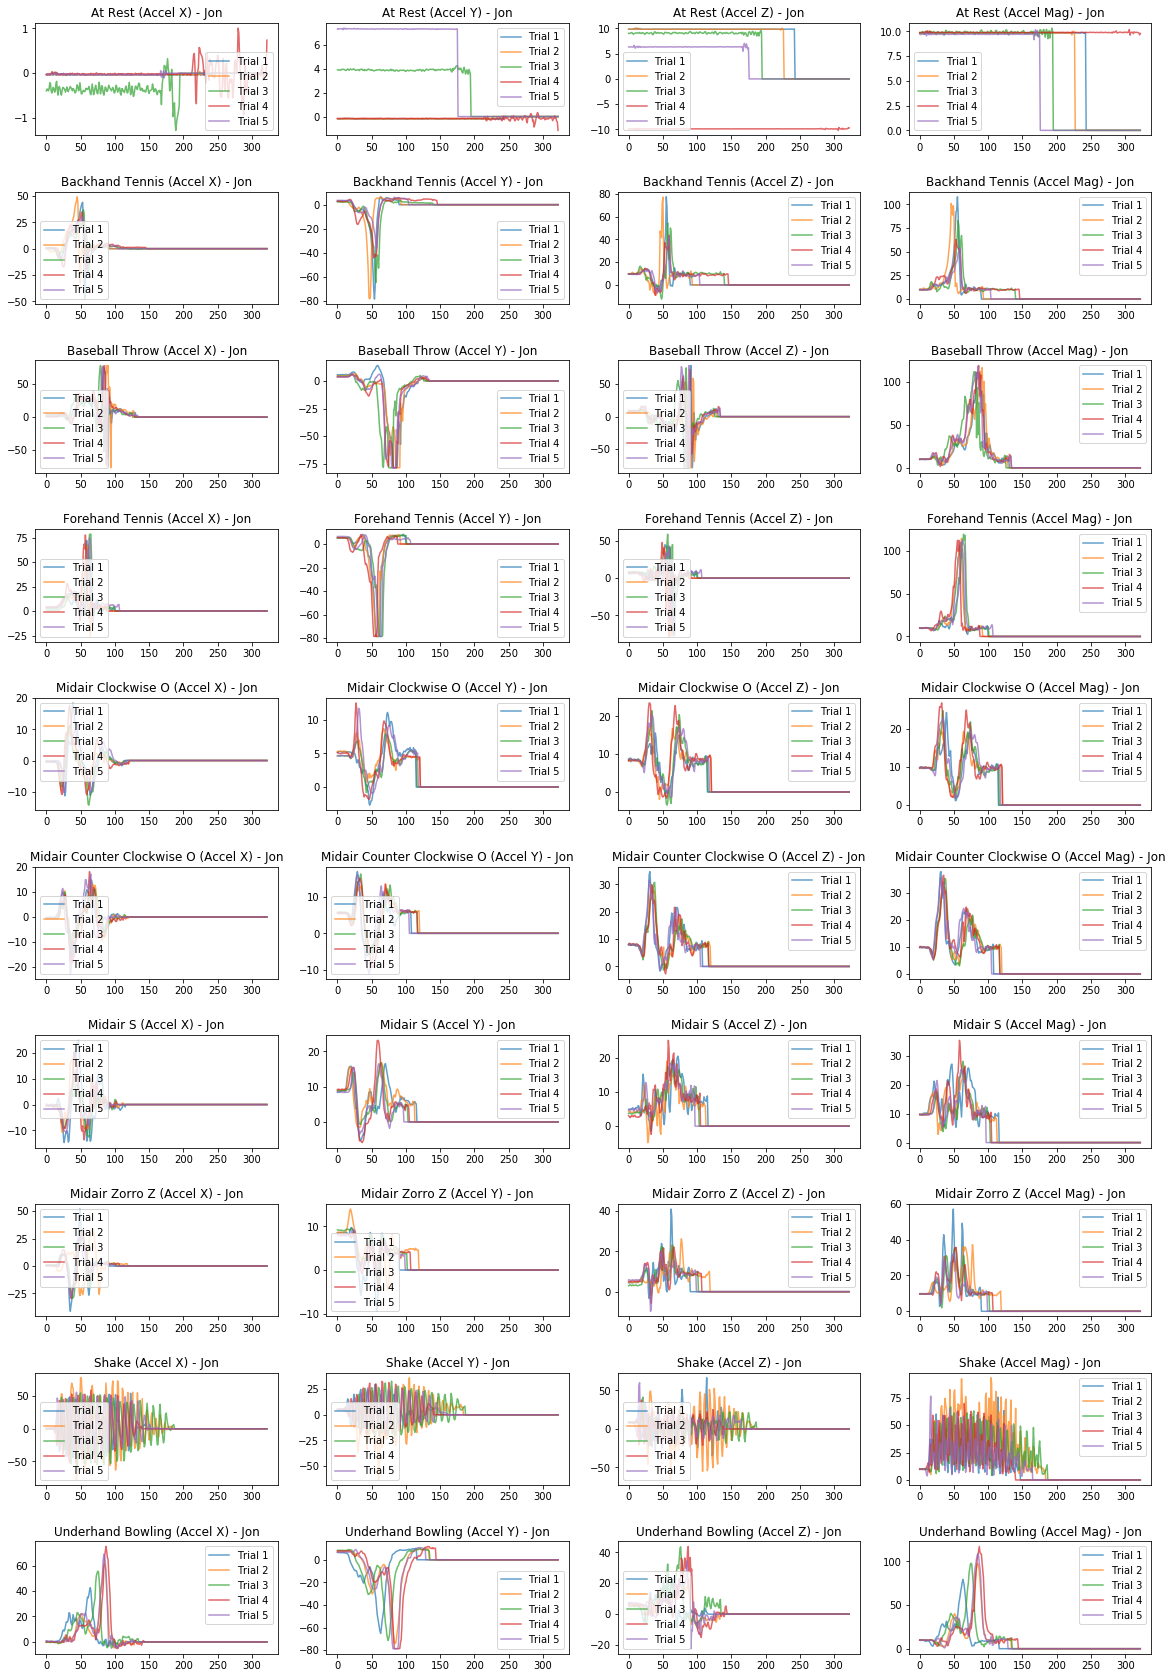

In [4]:
# Now let's plot all of the accel signals!

fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X) - Jon")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y) - Jon")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z) - Jon")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag) - Jon")
    axes[index][3].legend()
    index = index + 1


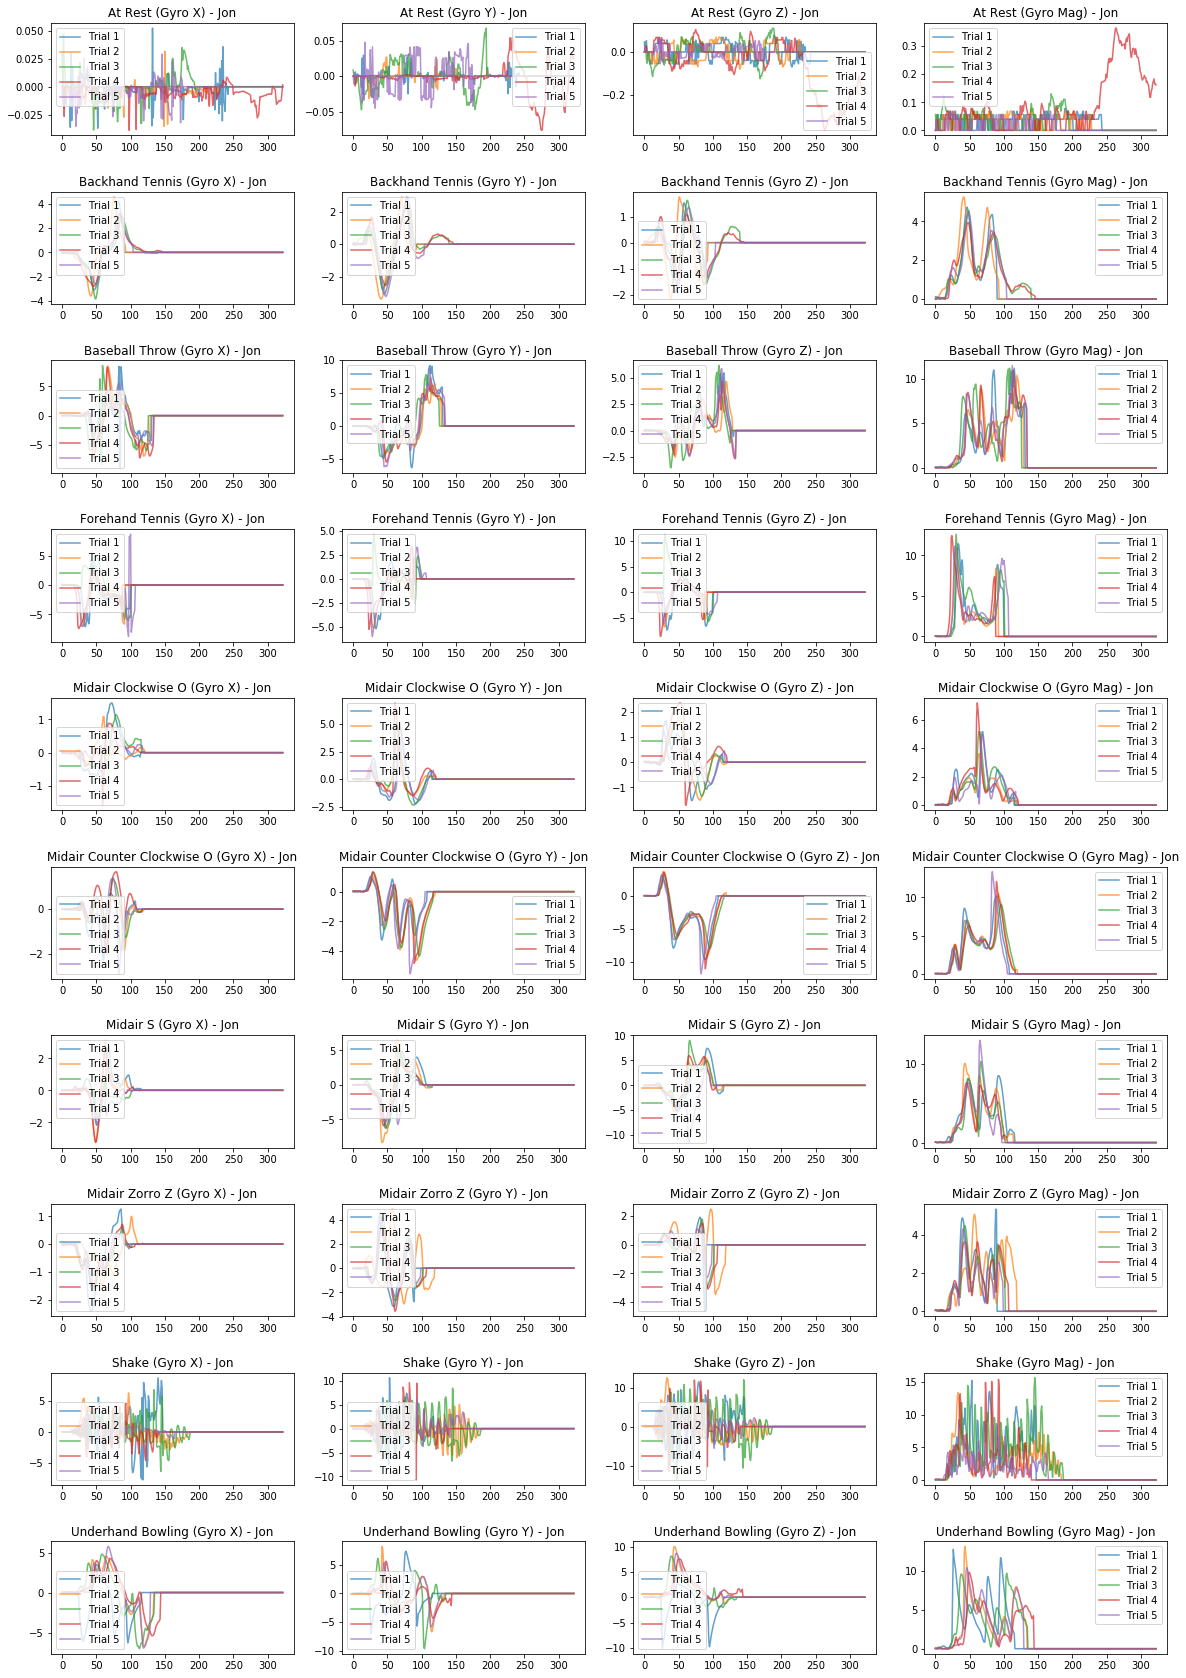

In [5]:
# Now let's plot all of the gyro signals! :)

fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.gyro.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.gyro.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.gyro.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.gyro.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Gyro X) - Jon")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Gyro Y) - Jon")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Gyro Z) - Jon")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Gyro Mag) - Jon")
    axes[index][3].legend()
    index = index + 1


### My Gesture Logs

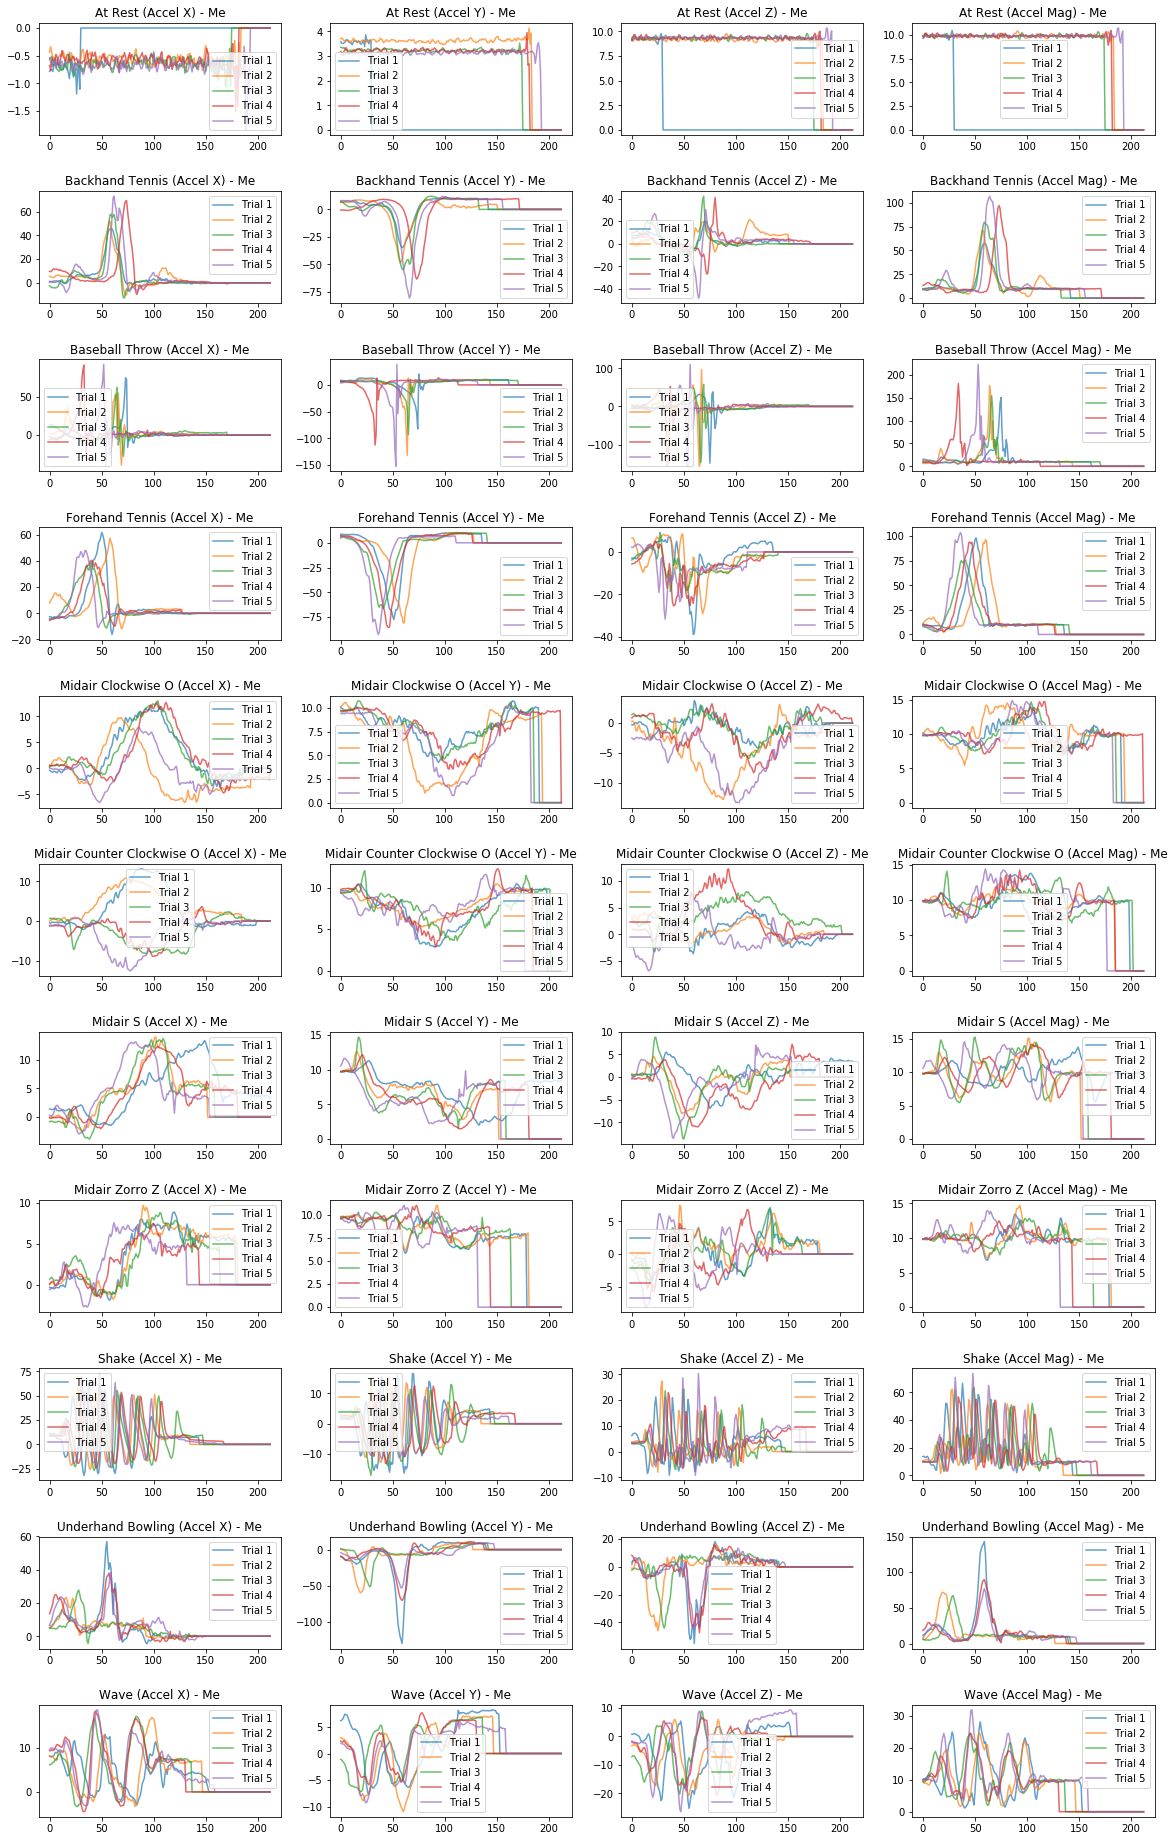

In [6]:
# plot all of the accel signals!

fig, axes = plt.subplots(len(mapGestureToTrials_me), 4, figsize=(20, 3 * len(mapGestureToTrials_me)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted_me = sorted(mapGestureToTrials_me.keys())
for gestureName in gestureNamesSorted_me:
    gestureTrials = mapGestureToTrials_me[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X) - Me")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y) - Me")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z) - Me")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag) - Me")
    axes[index][3].legend()
    index = index + 1


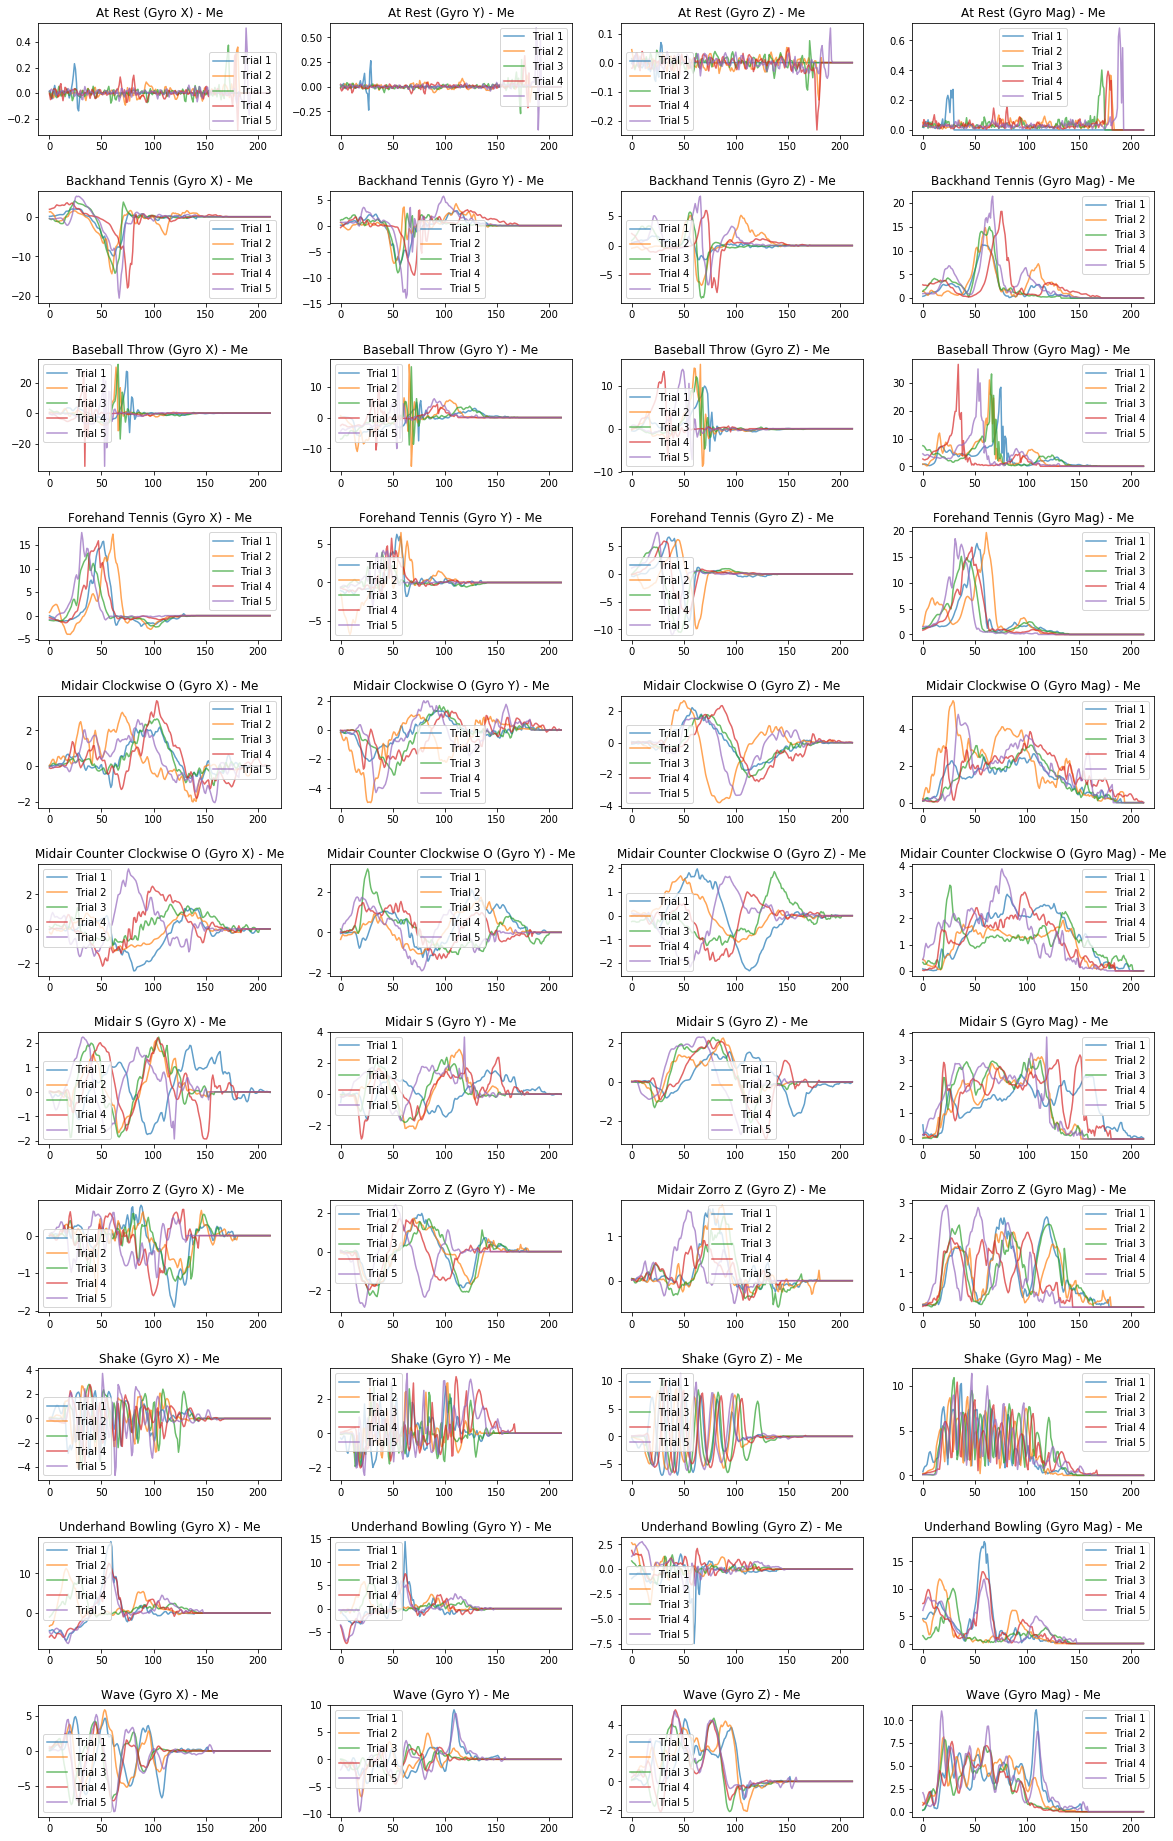

In [7]:
# Now let's plot all of the gyro signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials_me), 4, figsize=(20, 3 * len(mapGestureToTrials_me)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted_me = sorted(mapGestureToTrials_me.keys())
for gestureName in gestureNamesSorted_me:
    gestureTrials = mapGestureToTrials_me[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.gyro.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.gyro.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.gyro.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.gyro.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Gyro X) - Me")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Gyro Y) - Me")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Gyro Z) - Me")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Gyro Mag) - Me")
    axes[index][3].legend()
    index = index + 1


## Creating k-folds 

In [8]:
# k-fold validation
from random import randint

# Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial for that fold
# if createNewKFold is True, returns a new random fold, otherwise returns same fold setup as before 
# (this is to better enable repeat experimentation). WARNING: if you are trying to use multiple gesture datasets
# make sure you set createNewKFold=True
fixedFoldsToMapGestureToTrial = None
def generate_kfolds(mapGestureToTrials, numFolds=5, createNewKFold=False):
    global fixedFoldsToMapGestureToTrial
    
    if createNewKFold is False and fixedFoldsToMapGestureToTrial is not None:
        return fixedFoldsToMapGestureToTrial
    
    # Quick check to make sure that there are numFolds of gesture trials for each gesture
    for gestureName, trials in mapGestureToTrials.items():
        if numFolds != len(trials):
            raise ValueError("For the purposes of this assignment, the number of folds={} must equal the number of trials for each gesture. Gesture '{}' has {} trials"
                             .format(numFolds, gestureName, len(trials)))

    numGestures = len(mapGestureToTrials)
    tmpMapGestureToTrials = dict()
    for gestureName, trials in mapGestureToTrials.items():
        tmpMapGestureToTrials[gestureName] = list(trials)
    
    gestureNames = list(mapGestureToTrials.keys())

    # create folds
    foldToMapGestureToTrial = list()
    for i in range(0, numFolds):
        curFoldMapGestureToTrial = dict()
        foldToMapGestureToTrial.append(curFoldMapGestureToTrial)
        
        for j in range(0, numGestures):
            curGestureName = gestureNames[j]
            trialList = tmpMapGestureToTrials[curGestureName]
            randTrialIndex = 0
            if (len(trialList) > 0):
                randTrialIndex = randint(0, len(trialList) - 1)

            randTrial = trialList[randTrialIndex]
            curFoldMapGestureToTrial[curGestureName] = randTrial
            del trialList[randTrialIndex]
    
    if fixedFoldsToMapGestureToTrial is None:
        fixedFoldsToMapGestureToTrial = foldToMapGestureToTrial
    
    return foldToMapGestureToTrial

In [9]:
# Print out the folds
numFolds = 5
foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials, numFolds, createNewKFold=True)
foldToMapGestureToTrial_me = generate_kfolds(mapGestureToTrials_me, numFolds, createNewKFold=True)

# debug check folds

print("DEBUG: PRINTING OUT FOLDS")
print("Jon's gesture set:")
for foldIndex in range(len(foldToMapGestureToTrial)):
    print("Fold: ", foldIndex)
    fold = foldToMapGestureToTrial[foldIndex]

    for gestureName, trial in fold.items():
        print("\t Gesture: {} Trial: {}".format(gestureName, trial.trialNum))
        
print("My gesture set:")
for foldIndex in range(len(foldToMapGestureToTrial_me)):
    print("Fold: ", foldIndex)
    fold = foldToMapGestureToTrial_me[foldIndex]

    for gestureName, trial in fold.items():
        print("\t Gesture: {} Trial: {}".format(gestureName, trial.trialNum))

DEBUG: PRINTING OUT FOLDS
Jon's gesture set:
Fold:  0
	 Gesture: At Rest Trial: 4
	 Gesture: Backhand Tennis Trial: 4
	 Gesture: Baseball Throw Trial: 1
	 Gesture: Forehand Tennis Trial: 0
	 Gesture: Midair Clockwise O Trial: 1
	 Gesture: Midair Counter Clockwise O Trial: 2
	 Gesture: Midair S Trial: 4
	 Gesture: Midair Zorro Z Trial: 0
	 Gesture: Shake Trial: 4
	 Gesture: Underhand Bowling Trial: 4
Fold:  1
	 Gesture: At Rest Trial: 0
	 Gesture: Backhand Tennis Trial: 0
	 Gesture: Baseball Throw Trial: 0
	 Gesture: Forehand Tennis Trial: 3
	 Gesture: Midair Clockwise O Trial: 2
	 Gesture: Midair Counter Clockwise O Trial: 0
	 Gesture: Midair S Trial: 2
	 Gesture: Midair Zorro Z Trial: 1
	 Gesture: Shake Trial: 0
	 Gesture: Underhand Bowling Trial: 2
Fold:  2
	 Gesture: At Rest Trial: 3
	 Gesture: Backhand Tennis Trial: 2
	 Gesture: Baseball Throw Trial: 2
	 Gesture: Forehand Tennis Trial: 2
	 Gesture: Midair Clockwise O Trial: 3
	 Gesture: Midair Counter Clockwise O Trial: 4
	 Gesture

# Shape-Matching method

In [10]:
import sys
!{sys.executable} -m pip install fastdtw

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [64]:
# Build up a fastdtw classifier

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# draft below
# numFolds = get_min_num_of_trials(mapGestureToTrials)
# numGestures = len(mapGestureToTrials)
# numTrials = get_total_num_of_trials(mapGestureToTrials)
# foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials)


def dtwPredict(trial, trainFolds):
#    gestureNames=list(trainFolds[0].keys())
    closestGesture = gestureNames[0]
    
    for gestureName in gestureNames:    
        sumDistanceToGesture = 0
        
        for fold in trainFolds:
            trainingTrial = fold[gestureName]
            distance,path = fastdtw(trial.accel.mag, trainingTrial.accel.mag, dist=euclidean)
            sumDistanceToGesture = sumDistanceToGesture + distance
        
        if gestureName==gestureNames[0] or sumDistanceToGesture < closestDistance:
            closestDistance = sumDistanceToGesture
            closestGesture = gestureName
    
    return closestGesture


In [17]:
# Test our DTW using Jon's gesture set, fold 0 as testing fold for now
testFold = foldToMapGestureToTrial[0]

trainFolds = list()

for foldIndex in range(1,4):
    trainFolds.append(foldToMapGestureToTrial[foldIndex])

for gestureName, trial in testFold.items():
    print("Attempting to predict: {}".format(gestureName))
    dtwPrediction = dtwPredict(trial, trainFolds)
    print("DTW prediction: {}".format(dtwPrediction))

Attempting to predict: At Rest
DTW prediction: Midair Clockwise O
Attempting to predict: Backhand Tennis
DTW prediction: Backhand Tennis
Attempting to predict: Baseball Throw
DTW prediction: Baseball Throw
Attempting to predict: Forehand Tennis
DTW prediction: Forehand Tennis
Attempting to predict: Midair Clockwise O
DTW prediction: Midair Clockwise O
Attempting to predict: Midair Counter Clockwise O
DTW prediction: Midair Counter Clockwise O
Attempting to predict: Midair S
DTW prediction: Midair Clockwise O
Attempting to predict: Midair Zorro Z
DTW prediction: Midair Zorro Z
Attempting to predict: Shake
DTW prediction: Midair Zorro Z
Attempting to predict: Underhand Bowling
DTW prediction: Underhand Bowling


In [65]:
# k-fold validation for Dtw classifier

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def kfoldValidationDtw(foldToMapGestureToTrial):

    foldNum = len(foldToMapGestureToTrial)
    gestureNames = list(foldToMapGestureToTrial[0].keys())
    
    y_true = []
    y_pred = []
    
    
    for foldIndex in range(len(foldToMapGestureToTrial)):
        testFold = foldToMapGestureToTrial[foldIndex]
        trainFolds = []
        
        for i in range(len(foldToMapGestureToTrial)):
            if i != foldIndex:
                trainFolds.append(foldToMapGestureToTrial[i])

        for gestureName, trial in testFold.items():
            dtwPrediction = dtwPredict(trial, trainFolds)
            
            y_true.append(gestureName)
            y_pred.append(dtwPrediction)
            

# get confusion matrices
    labels = gestureNames
    cm = confusion_matrix(y_true, y_pred, labels)

# calculate accuracies
    numTrialsPerGesture = len(foldToMapGestureToTrial) # assume that we know all folds has equal size
    correctPredictionSum=0
    accuracyGestures = dict()
    
    for i in range(len(gestureNames)):    
        accuracyOfOneGesture = cm[i][i]/numTrialsPerGesture
        print("Accuracy on", gestureNames[i], accuracyOfOneGesture)
        accuracyGestures.update({gestureNames[i]: accuracyOfOneGesture})

        correctPredictionSum = correctPredictionSum + cm[i][i]
        
    accuracyOverall = correctPredictionSum / (len(gestureNames)*numTrialsPerGesture)
    print("Overall accuracy:", accuracyOverall)
                                              
            
# plot confusion matrices
    fig, axes = plt.subplots(1, figsize=(8, 8))
    plot_confusion_matrix(cm, classes=labels,
                          title='Confusion matrix (without normalization)')

    fig, axes = plt.subplots(1, figsize=(8, 8))
    plot_confusion_matrix(cm, classes=labels, normalize=True,
                          title='Confusion matrix (with normalization)')
    plt.show()

    return(accuracyGestures, accuracyOverall)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


K-fold validation for DTW classifier with Jon's Gesture:
Confusion matrix, without normalization
[[3 0 0 0 2 0 0 0 0 0]
 [0 3 0 2 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 2 0 3 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 2 3 0]
 [0 1 0 1 0 0 0 0 0 3]]
Normalized confusion matrix
[[0.6 0.  0.  0.  0.4 0.  0.  0.  0.  0. ]
 [0.  0.6 0.  0.4 0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.4 0.  0.6 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.4 0.6 0. ]
 [0.  0.2 0.  0.2 0.  0.  0.  0.  0.  0.6]]


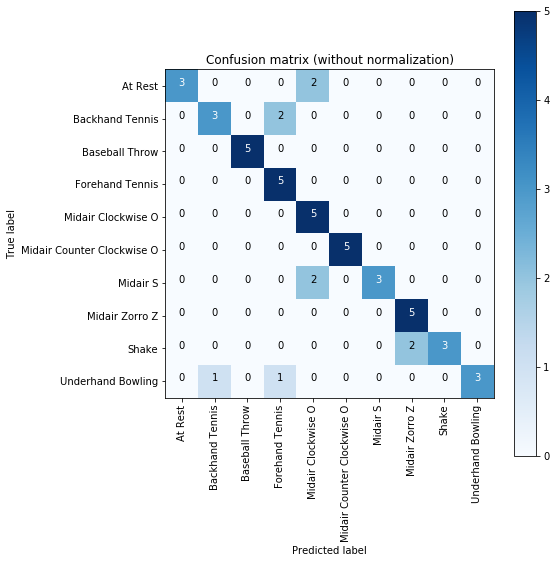

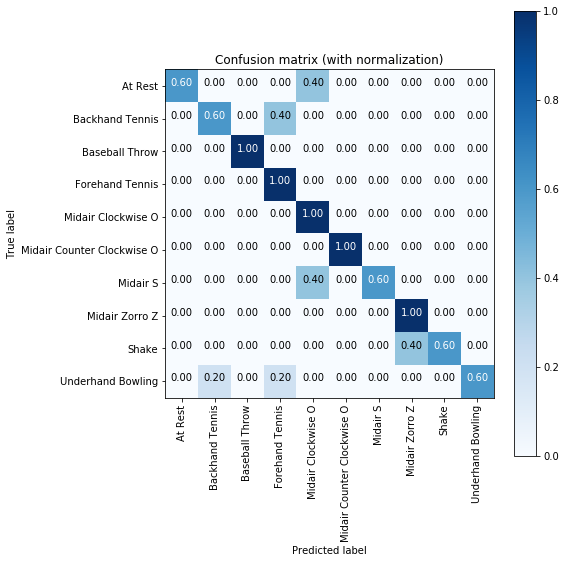

({'At Rest': 0.6,
  'Backhand Tennis': 0.6,
  'Baseball Throw': 1.0,
  'Forehand Tennis': 1.0,
  'Midair Clockwise O': 1.0,
  'Midair Counter Clockwise O': 1.0,
  'Midair S': 0.6,
  'Midair Zorro Z': 1.0,
  'Shake': 0.6,
  'Underhand Bowling': 0.6},
 0.8)

In [23]:
# K-fold validation for DTW classifier with Jon's Gesture:

print("K-fold validation for DTW classifier with Jon's Gesture:")
kfoldValidationDtw(foldToMapGestureToTrial)

K-fold validation for DTW classifier with my Gesture:
Accuracy on At Rest 0.8
Accuracy on Backhand Tennis 0.4
Accuracy on Baseball Throw 1.0
Accuracy on Forehand Tennis 1.0
Accuracy on Midair Clockwise O 0.2
Accuracy on Midair Counter Clockwise O 0.6
Accuracy on Midair S 0.0
Accuracy on Midair Zorro Z 1.0
Accuracy on Shake 1.0
Accuracy on Underhand Bowling 0.0
Accuracy on Wave 0.0
Overall accuracy: 0.5454545454545454
Confusion matrix, without normalization
[[4 0 0 0 0 0 0 1 0 0 0]
 [0 2 0 3 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 1 4 0 0 0 0 0]
 [0 0 0 0 1 3 0 1 0 0 0]
 [0 0 0 0 2 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 1 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 3 0 0 0]]
Normalized confusion matrix
[[0.8 0.  0.  0.  0.  0.  0.  0.2 0.  0.  0. ]
 [0.  0.4 0.  0.6 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.2 0.8 0.  0.  0.  0.  0. ]


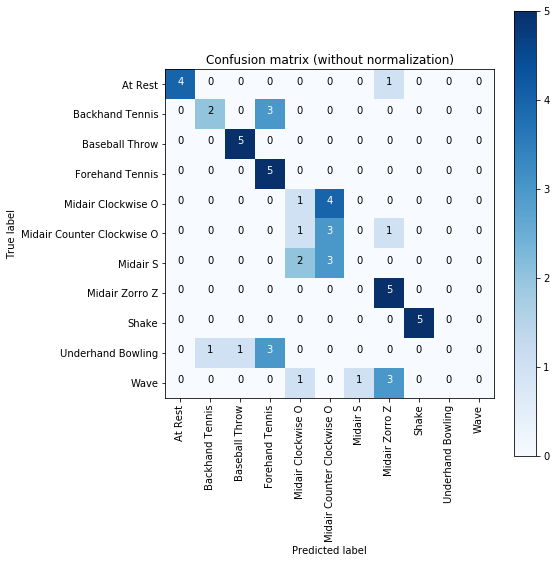

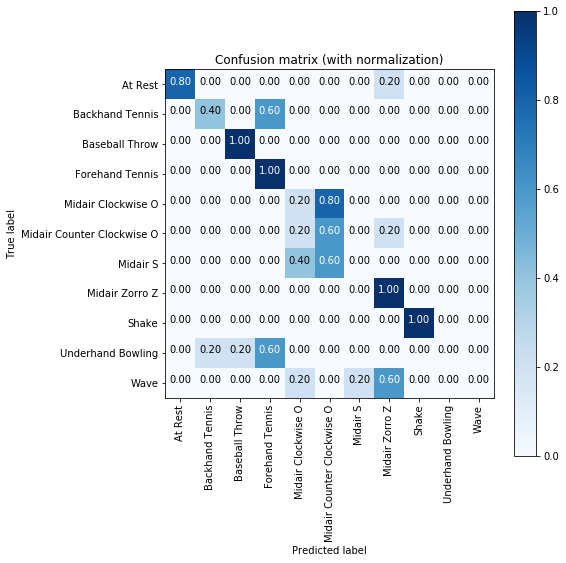

({'At Rest': 0.8,
  'Backhand Tennis': 0.4,
  'Baseball Throw': 1.0,
  'Forehand Tennis': 1.0,
  'Midair Clockwise O': 0.2,
  'Midair Counter Clockwise O': 0.6,
  'Midair S': 0.0,
  'Midair Zorro Z': 1.0,
  'Shake': 1.0,
  'Underhand Bowling': 0.0,
  'Wave': 0.0},
 0.5454545454545454)

In [66]:
# K-fold validation for DTW classifier with my Gestures:

print("K-fold validation for DTW classifier with my Gesture:")
kfoldValidationDtw(foldToMapGestureToTrial_me)

# Model-Based method

## Exploration of features

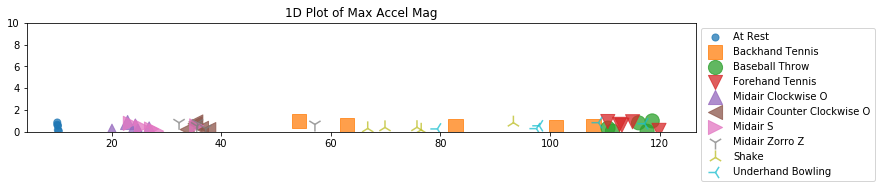

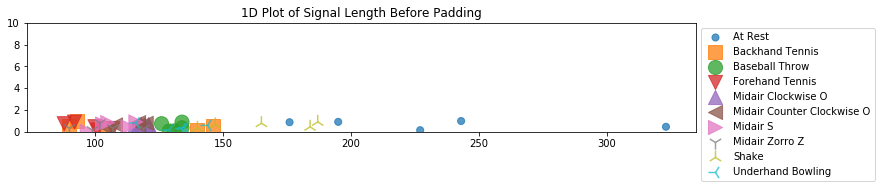

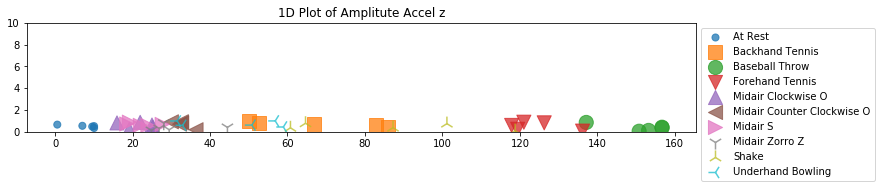

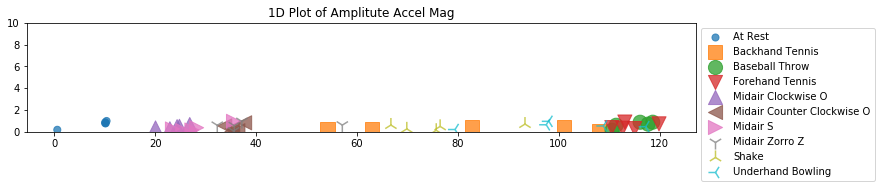

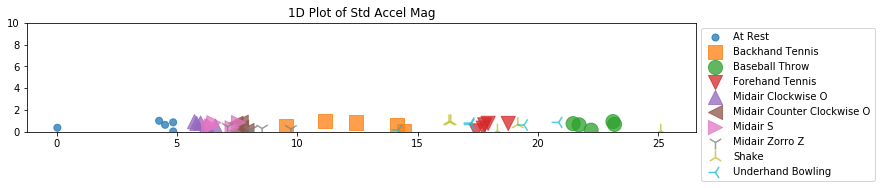

In [82]:
# Playing around with 1D Explorations of data

import itertools
import statistics as stats

mapMarkerToDesc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

# Plots 1: the maximum magnitude of each trial's acceleration signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 2))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.mag.max() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Max Accel Mag")
plt.show()


# Plot 2: the length of each gesture trial
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 2))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.signalLengthBeforePadding for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)
    
plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Signal Length Before Padding")
plt.show()


# My own exploration:
# Plot 3: the amplitude of each trial's acceleration signal on z-axis
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 2))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.z.max()-trial.accel.z.min() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Amplitute Accel z")
plt.show()


# Plot 4: the amplitude of each trial's acceleration signal 
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 2))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.mag.max()-trial.accel.mag.min() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Amplitute Accel Mag")
plt.show()


# Plot 5: the standard deviation of each trial's acceleration signal
# ref: https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray-in-python
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 2))
for gestureName, trials in mapGestureToTrials.items():
    x = list(stats.stdev(trial.accel.mag) for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Std Accel Mag")
plt.show()


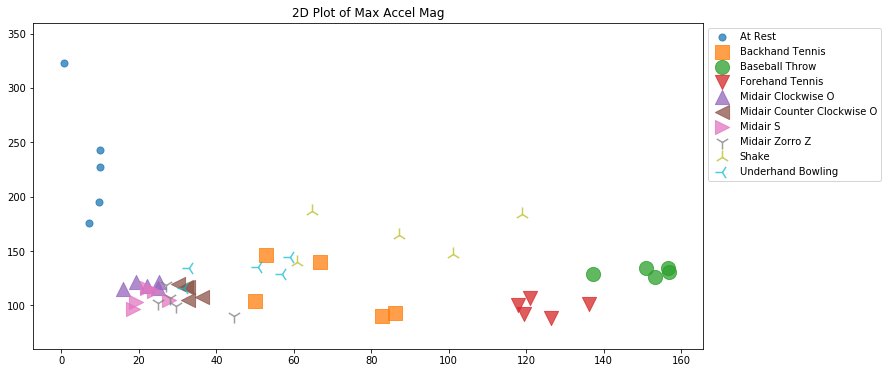

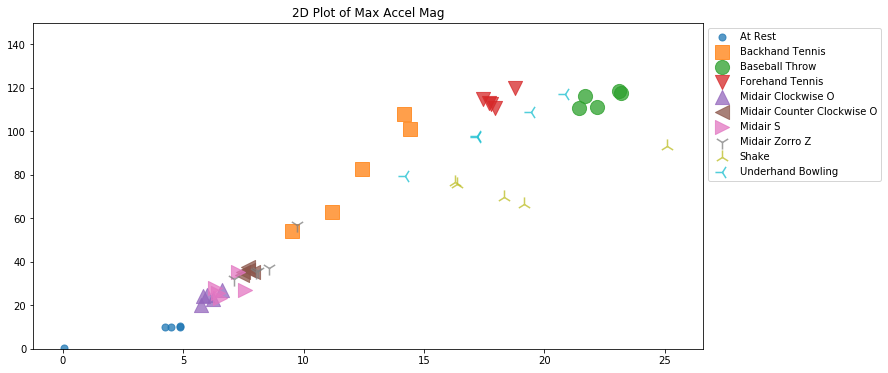

In [33]:
# Now explore the discriminability of 2 dimensions!


# Plot 1: accel.z.max + signalLengthBeforePadding 
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.z.max()-trial.accel.z.min() for trial in trials)
    y = list(trial.accel.signalLengthBeforePadding for trial in trials)
    s = 200
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((60,360))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("2D Plot of Max Accel Mag")
plt.show()


# Plot 2: accel.z.max + signalLengthBeforePadding 
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(stats.stdev(trial.accel.mag) for trial in trials)
    y = list(trial.accel.mag.max()-trial.accel.mag.min() for trial in trials)
    s = 200
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,150))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("2D Plot of Max Accel Mag")
plt.show()



## Build SVM classifier

In [85]:
# Build up svm classifier & k-fold validation

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def kfoldValidationSvm(foldToMapGestureToTrial):

#First, sort out set fold and training folds
    mapGestureNameToCorrectMatchCnt = dict()
    mapGestureNameToPredictionResultList = dict()
    trainingData = np.array([])
    classLabels = np.array([])

    foldNum = len(foldToMapGestureToTrial)
    gestureNames = list(foldToMapGestureToTrial[0].keys())
    
    y_true = []
    y_pred = []
    
    for foldIndex in range(foldNum):
        testFold = foldToMapGestureToTrial[foldIndex]
        
        for i in range(foldNum):
            if i != foldIndex:
                # fold = foldToMapGestureToTrial[]
                
                for gestureName, trial in foldToMapGestureToTrial[i].items():
                    trainingData = np.append(trainingData, trial.accel.mag.max())
                    classLabels = np.append(classLabels, trial.gestureName)
                    
        trainingData = trainingData.reshape(-1, 1) 
        
        clf = svm.SVC()
        clf.fit(trainingData, classLabels) 

        for gestureName, trial in testFold.items():
            # print("Attempting to predict: {}".format(gestureName))
            
            svmPrediction = clf.predict(trial.accel.mag.max())
            # print("SVM prediction: {}".format(svmPrediction[0]))
            
            y_true.append(gestureName)
            y_pred.append(svmPrediction)

            
# get data in confusion matrices
    labels = gestureNames
    cm = confusion_matrix(y_true, y_pred, labels)
    
   
# calculate accuracies
    numTrialsPerGesture = len(foldToMapGestureToTrial) # assume that we know all folds has equal size
    correctPredictionSum=0
    accuracyGestures = dict()
    
    for i in range(len(gestureNames)):    
        accuracyOfOneGesture = cm[i][i]/numTrialsPerGesture
        print("Accuracy on:", gestureNames[i], accuracyOfOneGesture)

        accuracyGestures.update({gestureNames[i]: accuracyOfOneGesture})
        correctPredictionSum = correctPredictionSum + cm[i][i]
        
    accuracyOverall = correctPredictionSum / (len(gestureNames)*numTrialsPerGesture)
    print("Overall accuracy:", accuracyOverall)
                                     

    
# plot confusion matrices
    fig, axes = plt.subplots(1, figsize=(8, 8))
    plot_confusion_matrix(cm, classes=labels,
                          title='Confusion matrix (without normalization)')

    fig, axes = plt.subplots(1, figsize=(8, 8))
    plot_confusion_matrix(cm, classes=labels, normalize=True,
                          title='Confusion matrix (with normalization)')
    plt.show()



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Accuracy on: At Rest 1.0
Accuracy on: Backhand Tennis 1.0
Accuracy on: Baseball Throw 0.8
Accuracy on: Forehand Tennis 0.8
Accuracy on: Midair Clockwise O 0.8
Accuracy on: Midair Counter Clockwise O 0.6
Accuracy on: Midair S 0.6
Accuracy on: Midair Zorro Z 0.2
Accuracy on: Shake 1.0
Accuracy on: Underhand Bowling 0.6
Overall accuracy: 0.74
Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 1]
 [0 0 1 4 0 0 0 0 0 0]
 [0 1 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 3 0 2 0 0]
 [0 0 0 0 1 1 3 0 0 0]
 [0 1 0 0 0 3 0 1 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 1 1 0 0 0 0 0 0 3]]
Normalized confusion matrix
[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.2]
 [0.  0.  0.2 0.8 0.  0.  0.  0.  0.  0. ]
 [0.  0.2 0.  0.  0.8 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.6 0.  0.4 0.  0. ]
 [0.  0.  0.  0.  0.2 0.2 0.6 0.  0.  0. ]
 [0.  0.2 0.  0.  0.  0.6 0.  0.2 0.  0. ]
 [0.  0.  0.  0

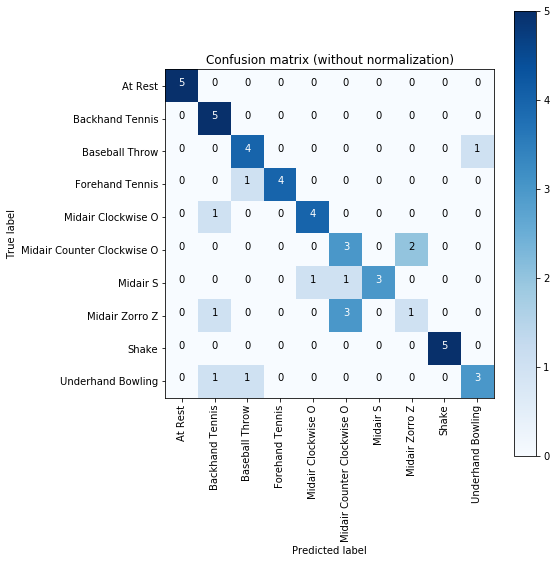

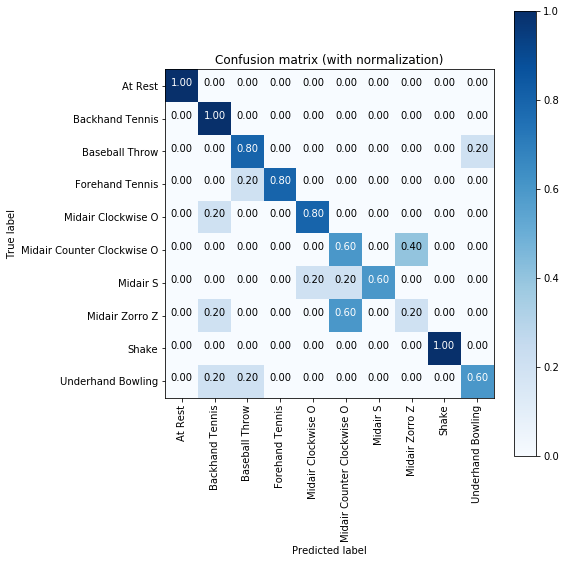

In [86]:
kfoldValidationSvm(foldToMapGestureToTrial)

Accuracy on: At Rest 1.0
Accuracy on: Backhand Tennis 0.6
Accuracy on: Baseball Throw 1.0
Accuracy on: Forehand Tennis 0.8
Accuracy on: Midair Clockwise O 0.8
Accuracy on: Midair Counter Clockwise O 0.4
Accuracy on: Midair S 0.0
Accuracy on: Midair Zorro Z 0.6
Accuracy on: Shake 1.0
Accuracy on: Underhand Bowling 0.8
Accuracy on: Wave 1.0
Overall accuracy: 0.7272727272727273
Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 1 1 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 1 0 0]
 [0 0 0 0 4 1 0 0 0 0 0]
 [0 0 0 0 1 2 1 1 0 0 0]
 [0 0 0 0 3 2 0 0 0 0 0]
 [0 0 0 0 1 1 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 1 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0 5]]
Normalized confusion matrix
[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.6 0.  0.  0.  0.  0.  0.  0.2 0.2 0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.8 0.  0.  0.  0.  0.2 0.  0. ]
 [0.  0.  0.  0.  0.8 0.2 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.2 0.4 0.2 0.2 0.  0.  0

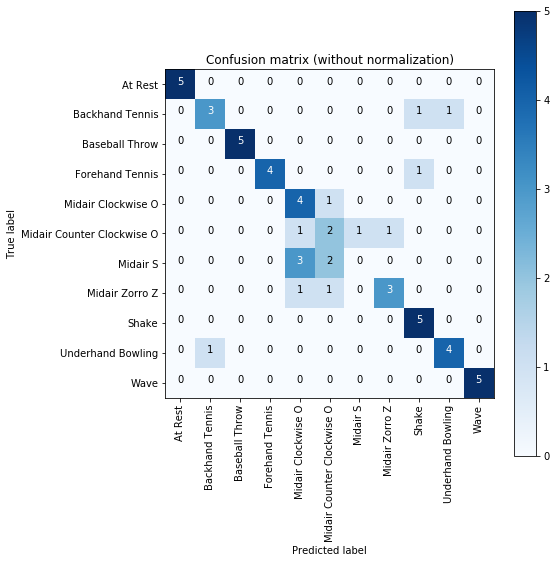

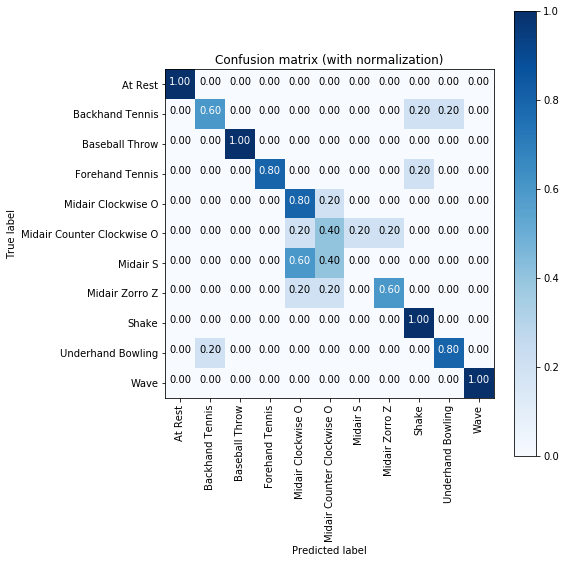

In [87]:
kfoldValidationSvm(foldToMapGestureToTrial_me)